# Analyzing CIA Factbook Data Using SQLite and Python

In this project, we are woriking with data from the CIA World Factbook, a compendium of statistic about all of the countries on Earth. The SQLite Database, `factbook.db`, can be download [here](https://github.com/factbook/factbook.sql/releases). The Factbook contains some main information like:

|Name                    |Description                                                              |
|------------------------|-------------------------------------------------------------------------|
|`name`                  |The name of the country                                                  |
|`area`                  |The total land and water area                                            |
|`area_land`             |The country's land area in km2                                           |
|`area_water`            |The country's water area in km2                                          |
|`population`            |The population as of 2015                                                |
|`population_growth`     |The annual population growth rate (percentage)                           |
|`birth-rate`            |The country's birth rate, or the number of births a year per 1,000 people|
|`death_rate`            |The country's death rate, or the number of deaths a year per 1,000 people|

## Overview of the Data

In [1]:
import pandas as pd
import sqlite3

# connect sqlite to the database
conn = sqlite3.connect('factbook.db')

# write a query that returns the first 5 rows of the 'facts' table in the database
query = "SELECT * FROM facts LIMIT 5;"

#run the query
pd.read_sql_query(query, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


## Summary Statistics

Write a single query that returns the minimum population, maximum population, minimum population growth and maximum population growth

In [3]:
pop = """
SELECT MIN(population) 'min population', 
MAX(population) 'max population', MIN(population_growth) 'min population growth', 
MAX(population_growth) 'max population growth' FROM facts"""

pd.read_sql_query(pop, conn)

,min population,max population,min population growth,max population growth
0,0,7256490011,0.0,4.02


There are some anomalies here:
- a country with a population of 0
- a country with a population of 7,256,490,111 (which is more than 7.2 billion people)

Let's zoom in on just these countries.

## Exploring Outliers

In [5]:
min_pop = """
SELECT name FROM facts WHERE population == (select min(population) from facts)"""

max_pop = """
SELECT name FROM facts WHERE population == (select max(population) from facts)"""

print(pd.read_sql_query(min_pop, conn))
print(pd.read_sql_query(max_pop, conn))

         name
0  Antarctica
    name
0  World


In fact, in Antarctica there is no human being because of its climat. And the one that has more than 7.2 billion people is actually the World.

## Histograms

Let's move on to generating histograms for the rest of the countries in the table, ingnoring those 2 rows. 

C:\Users\Vinh Phuc\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3267: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012D469F8BE0>,
      dtype=object)

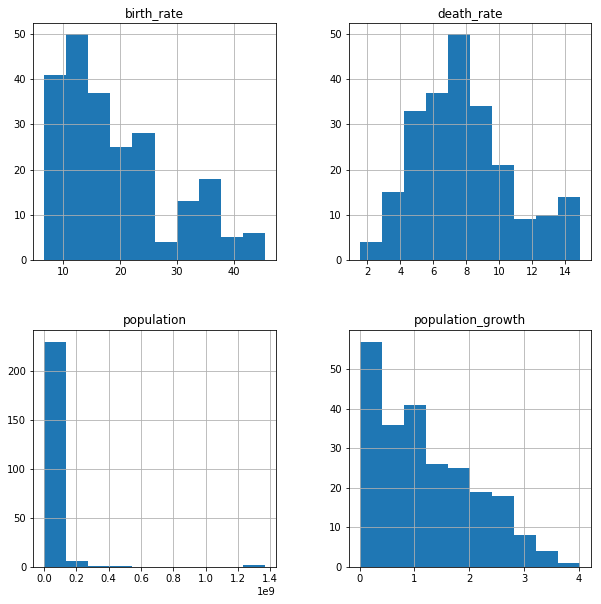

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

q = """
SELECT population, population_growth, birth_rate, death_rate
FROM facts
WHERE population != (select max(population) from facts)
AND population != (select min(population) from facts)
"""
pd.read_sql_query(q,conn).hist(ax=ax)

## Which countries have the highest population density ?

In [11]:
q_density = """
SELECT name, CAST(population as float) / CAST(area_land as float) density
FROM facts
WHERE population != (select min(population) from facts)
AND population != (select max(population) from facts)
ORDER BY density DESC
LIMIT 20
"""
# Top 20 countries that have the highest population density
top_20_density = pd.read_sql_query(q_density, conn)
top_20_density

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8259.784571
3,Hong Kong,6655.271202
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


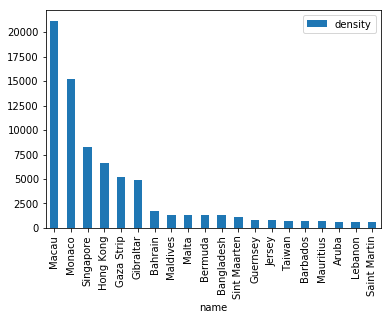

In [18]:
top_20_density.plot.bar(x = "name")

Macau has likely the highest population density in the world, with more than 20,000 people per km2. 

## Which countries have more water than land ?

In [19]:
ratio_w_l = """
SELECT name, CAST(area_water as float) / CAST(area_land as float) ratio
FROM facts
WHERE ratio > 1
LIMIT 20
"""

# Top 20 countries that have more water than land
pd.read_sql_query(ratio_w_l, conn)

,name,ratio
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
